In [2]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Change directory to the package folder 
%cd '/content/drive/MyDrive/Colab Notebooks/code'
# Verify the contents of the current folder 
!ls

/content/drive/MyDrive/Colab Notebooks/code
datasets    main_linear.py	   main_triplet.py  save
losses.py   main_supcon_no_aug.py  __pycache__	    util.py
main_ce.py  main_supcon.py	   resnet.py


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/code


In [12]:
import torch
import numpy as np
from torchvision import transforms, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from resnet import SupCEResNet,SupConResNet
from sklearn.neighbors import KNeighborsClassifier

load the SupCon model with no augmentation

In [5]:
ckpt = torch.load("save/SupCon/cifar10_models/SupCon_no_aug/last.pth", map_location='cpu')
state_dict = ckpt['model']
new_state_dict = {}
for k, v in state_dict.items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
state_dict = new_state_dict

In [6]:
#model = SupCEResNet(name='resnet50', num_classes=10)
model = SupConResNet(name='resnet50')
model = model.cuda()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
def set_loader():
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = datasets.CIFAR10(root='./datasets/',
                                         transform=train_transform,
                                         download=True)
    val_dataset = datasets.CIFAR10(root='./datasets/',train=False,
                                       transform=val_transform)
    
    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=256, shuffle=(
            train_sampler is None),
        num_workers=2, pin_memory=True, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=256, shuffle=False,
        num_workers=2, pin_memory=True)

    return train_loader, val_loader

In [8]:
# run the training and validation samples throught the encoder to get the embeddings
train_loader,val_loader = set_loader()
train_embeddings = np.zeros(shape=(0, 2048))
train_labels = np.zeros(shape=(0))
val_embeddings = np.zeros(shape=(0, 2048))
val_labels = np.zeros(shape=(0))
model.eval()
with torch.no_grad():
    for image, label in iter(train_loader):
        image = image.float().cuda()
        emb = F.normalize(model.encoder(image), dim=1)
        train_labels = np.concatenate((train_labels, label.numpy().ravel()))
        train_embeddings = np.concatenate([train_embeddings, emb.detach().cpu().numpy()], axis=0)
    for image, label in iter(val_loader):
        image = image.float().cuda()
        emb = F.normalize(model.encoder(image), dim=1)
        val_labels = np.concatenate((val_labels, label.numpy().ravel()))
        val_embeddings = np.concatenate([val_embeddings, emb.detach().cpu().numpy()], axis=0)

Files already downloaded and verified


Text(0.5, 1.0, 'PCA projected embeddings')

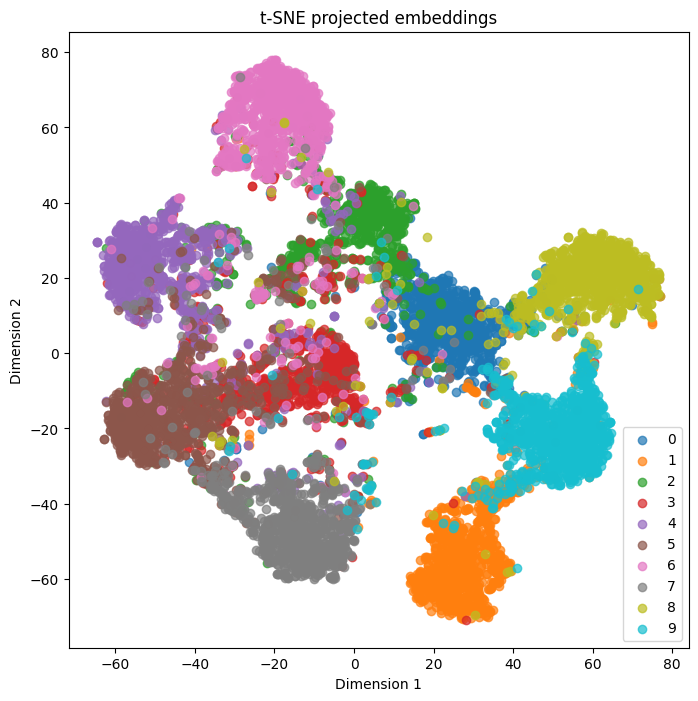

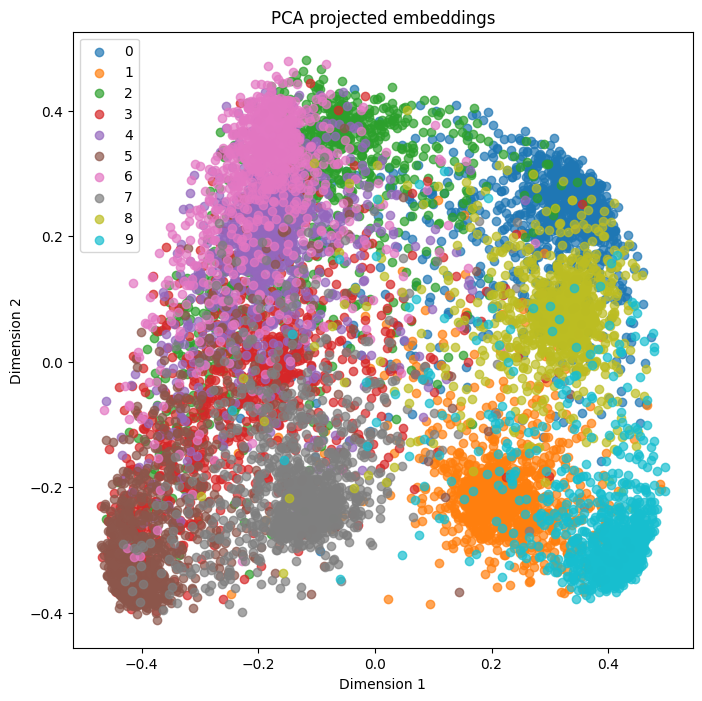

In [11]:
# visualize the vlidation embeddings via 2-dimensional t-SNE and PCA projections
# adapted from https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42
tsne = TSNE(2)
tsne_proj = tsne.fit_transform(val_embeddings)
cmap = colormaps['tab10']
fig, ax = plt.subplots(figsize=(8, 8))
for lab in range(10):
    indices = val_labels == lab
    ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], c=np.array(
        cmap(lab)).reshape(1, 4), label=lab, alpha=0.7)
ax.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title("t-SNE projected embeddings")

pca = PCA(n_components=2)
pca_proj = pca.fit_transform(val_embeddings)
fig, ax = plt.subplots(figsize=(8, 8))
for lab in range(10):
    indices = val_labels == lab
    ax.scatter(pca_proj[indices, 0], pca_proj[indices, 1], c=np.array(
        cmap(lab)).reshape(1, 4), label=lab, alpha=0.7)
ax.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title("PCA projected embeddings")

In [14]:
# KNN classifier trained on PCA projected training embeddings
knn = KNeighborsClassifier()
pca = PCA(n_components=10)
train_proj = pca.fit_transform(train_embeddings)
knn.fit(train_proj, train_labels)
# predict validation labels
val_proj = pca.transform(val_embeddings)
knn.score(val_proj, val_labels)

0.8399

load the CE supervised learning model

In [15]:
ckpt = torch.load("save/SupCon/cifar10_models/SupCE_cifar10_resnet50_lr_0.05_decay_0.0001_bsz_256_trial_0/last.pth", map_location='cpu')
state_dict = ckpt['model']
new_state_dict = {}
for k, v in state_dict.items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
state_dict = new_state_dict

In [16]:
model = SupCEResNet(name='resnet50', num_classes=10)
#model = SupConResNet(name='resnet50')
model = model.cuda()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
# run the training and validation samples throught the encoder to get the embeddings
train_loader,val_loader = set_loader()
train_embeddings = np.zeros(shape=(0, 2048))
train_labels = np.zeros(shape=(0))
val_embeddings = np.zeros(shape=(0, 2048))
val_labels = np.zeros(shape=(0))
model.eval()
with torch.no_grad():
    for image, label in iter(train_loader):
        image = image.float().cuda()
        emb = F.normalize(model.encoder(image), dim=1)
        train_labels = np.concatenate((train_labels, label.numpy().ravel()))
        train_embeddings = np.concatenate([train_embeddings, emb.detach().cpu().numpy()], axis=0)
    for image, label in iter(val_loader):
        image = image.float().cuda()
        emb = F.normalize(model.encoder(image), dim=1)
        val_labels = np.concatenate((val_labels, label.numpy().ravel()))
        val_embeddings = np.concatenate([val_embeddings, emb.detach().cpu().numpy()], axis=0)

Files already downloaded and verified


Text(0.5, 1.0, 'PCA projected embeddings')

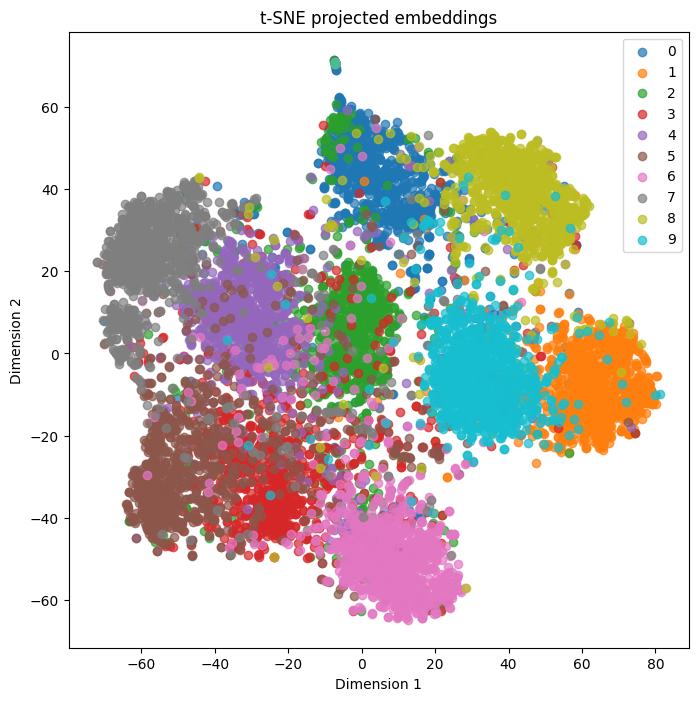

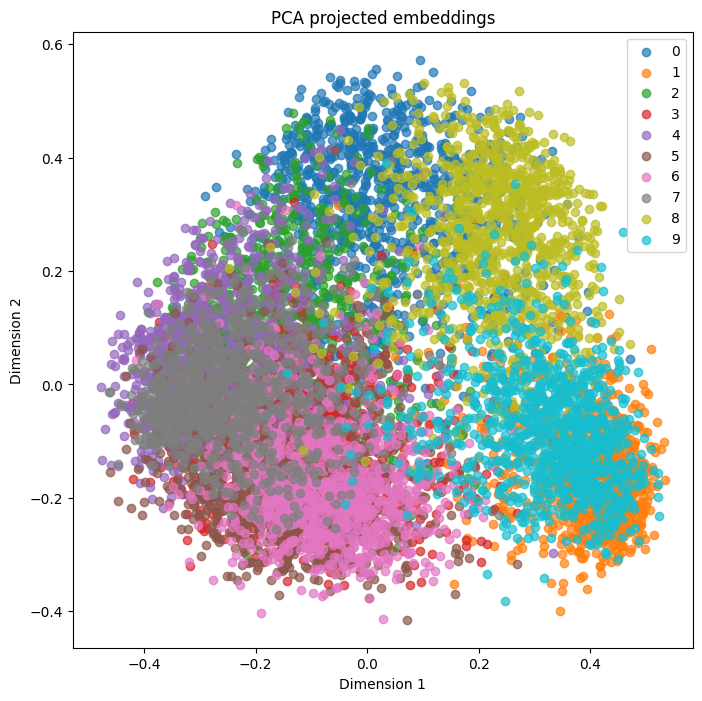

In [18]:
# visualize the vlidation embeddings via 2-dimensional t-SNE and PCA projections
# adapted from https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42
tsne = TSNE(2)
tsne_proj = tsne.fit_transform(val_embeddings)
cmap = colormaps['tab10']
fig, ax = plt.subplots(figsize=(8, 8))
for lab in range(10):
    indices = val_labels == lab
    ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], c=np.array(
        cmap(lab)).reshape(1, 4), label=lab, alpha=0.7)
ax.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title("t-SNE projected embeddings")

pca = PCA(n_components=2)
pca_proj = pca.fit_transform(val_embeddings)
fig, ax = plt.subplots(figsize=(8, 8))
for lab in range(10):
    indices = val_labels == lab
    ax.scatter(pca_proj[indices, 0], pca_proj[indices, 1], c=np.array(
        cmap(lab)).reshape(1, 4), label=lab, alpha=0.7)
ax.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title("PCA projected embeddings")

In [19]:
# KNN classifier trained on PCA projected training embeddings
knn = KNeighborsClassifier()
pca = PCA(n_components=10)
train_proj = pca.fit_transform(train_embeddings)
knn.fit(train_proj, train_labels)
# predict validation labels
val_proj = pca.transform(val_embeddings)
knn.score(val_proj, val_labels)

0.8242